<a href="https://colab.research.google.com/github/andigu/crbm/blob/main/H2_CRBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit emcee numdifftools pyscf > /dev/null

In [ ]:
import emcee
import tensorflow as tf 
import tensorflow_probability as tfp
import numpy as np 
from sklearn.neural_network import BernoulliRBM
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import imageio
from datetime import datetime
import os
from qiskit.quantum_info import Statevector, Pauli, Operator
from qiskit.visualization import plot_bloch_multivector, plot_bloch_vector, plot_histogram, plot_state_paulivec
from qiskit.visualization.utils import _bloch_multivector_data
from tqdm.keras import TqdmCallback
from scipy import optimize as opt
import numdifftools as nd

from qiskit.aqua.algorithms import VQE, NumPyEigensolver
import matplotlib.pyplot as plt
import numpy as np
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit.aqua.operators import Z2Symmetries
from qiskit import IBMQ, BasicAer, Aer
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry import FermionicOperator
from qiskit import IBMQ
from qiskit.aqua.operators import Z2Symmetries
import gc
gc.collect()

/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/__init__.py:170: DeprecationWarning: The package qiskit.chemistry is deprecated. It was moved/refactored to qiskit_nature (pip install qiskit-nature). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  warn_package('chemistry', 'qiskit_nature', 'qiskit-nature')


0

In [ ]:
# def get_qubit_op(dist):
#     driver = PySCFDriver(atom=f'H .0 .0 {-dist/2}; H .0 .0 {dist/2}', unit=UnitsType.ANGSTROM, charge=0, spin=0, basis='631g')
#     molecule = driver.run()
#     num_particles = molecule.num_alpha + molecule.num_beta
#     qubitOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals).mapping(map_type='parity')
#     # qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
#     return qubitOp.to_opflow(), molecule.nuclear_repulsion_energy

def get_qubit_op(dist):
    atom=f'H .0 .0 {-dist/2}; H .0 .0 {dist/2}'
    driver = PySCFDriver(atom=atom, unit=UnitsType.ANGSTROM, 
                         charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    num_particles = molecule.num_alpha + molecule.num_beta
    qubitOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals).mapping(map_type='parity')
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    return qubitOp.to_opflow(), molecule.nuclear_repulsion_energy

tmp = []
var = []
ds = np.arange(0.5,1,0.1)
for dist in ds:
    op, repulsion = get_qubit_op(dist)
    sv = Statevector(np.linalg.eigh(op.to_matrix())[1][:,0])
    tmp.append(np.linalg.eigvalsh(op.to_matrix()).min() + repulsion)
    expect = np.real(np.array([sv.expectation_value(o.to_matrix())/o.coeff for o in op]))
    coeffs = np.array([o.coeff for o in op])
    var.append(np.sum(coeffs**2 * (1-expect**2)))

/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/fermionic_operator.py:386: DeprecationWarning: The package qiskit.aqua.operators is deprecated. It was moved/refactored to qiskit.opflow (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  pauli_list = WeightedPauliOperator(paulis=[])
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/fermionic_operator.py:394: DeprecationWarning: The variable qiskit.aqua.aqua_globals is deprecated. It was moved/refactored to qiskit.utils.algorithm_globals (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  task_args=(threshold,), num_processes=aqua_globals.num_processes)


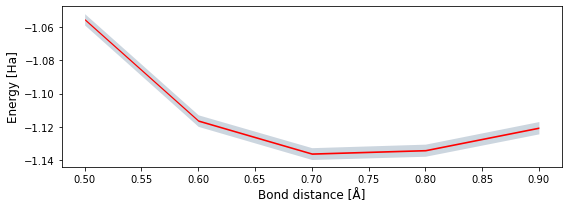

In [ ]:
fig = plt.figure(figsize=(8,3))

tmp, std = np.array(tmp), np.sqrt(np.array(var))/30
plt.fill_between(ds, y1=tmp-std/2, y2=tmp+std/2, alpha=0.2, color='#003262', lw=0)
eps = 0.001
plt.fill_between(ds, y1=tmp-eps/2, y2=tmp+eps/2, color='red', lw=0)
plt.xlabel('Bond distance [Å]', fontsize=12)
plt.ylabel('Energy [Ha]', fontsize=12)
plt.tight_layout()
plt.savefig('lih-curve.png', transparent=True)

In [ ]:
import itertools

class CRBM(tf.keras.models.Model):
    def __init__(self, nv=1, nh=5, seed=0, W=None, bv=None, bh=None, n_particles=10):
        np.random.seed(seed)
        tf.random.set_seed(seed)
        super(CRBM, self).__init__()
        self.nv, self.nh = nv, nh
        bv = CRBM.random_normal((n_particles,nv,1)) if bv is None else bv
        bh = CRBM.random_normal((n_particles,nh,1), loc=-0.5) if bh is None else bh
        W = CRBM.random_normal((n_particles,nv,nh)) if W is None else W
        self.bv = tf.Variable(initial_value=bv, dtype=tf.dtypes.complex64, trainable=True)
        self.bh = tf.Variable(initial_value=bh, dtype=tf.dtypes.complex64, trainable=True)
        self.W = tf.Variable(initial_value=W, dtype=tf.dtypes.complex64, trainable=True)
        self.n_particles = n_particles
        v_vecs = np.array([list("{0:b}".format(x).zfill(nv)) for x in np.arange(2**nv)]).astype(np.int)
        self.v_vecs = tf.cast(tf.convert_to_tensor(v_vecs), tf.dtypes.complex64)
    
    @staticmethod
    def random_normal(shape, scale=0.5, loc=0):
        return np.random.normal(size=shape, scale=scale, loc=loc) + 1j*np.random.normal(size=shape, scale=scale, loc=loc)
    
    def psi(self, v, pid=0):
        """
        Accepts only length N binary strings
        """
        if tf.rank(v) == 1:
            v = tf.expand_dims(v, axis=-1)
        elif tf.rank(v) == 2:
            v = tf.transpose(v)
        bv, bh, W = self.bv[pid], self.bh[pid], self.W[pid]
        ret = tf.linalg.adjoint(bv) @ v + tf.reduce_sum(tf.math.log(tf.math.conj(tf.exp(bh + tf.linalg.adjoint(W) @ v)) + 1), axis=0)
        return tf.transpose(tf.exp(ret))
    
    def statevector(self):
        scores = []
        for i in range(self.n_particles):
            scores.append(tf.math.reduce_mean(tf.math.log(self.prob(measurements, pid=i))).numpy())
        pid = np.argmax(scores)
        psi2 = self.psi(self.v_vecs, pid=pid).numpy().flatten()
        psi2 = psi2/psi2[0]
        psi2 = psi2/np.linalg.norm(psi2)
        return Statevector(psi2)

    def prob(self, measurements, pid=0):
        psi_vec = self.psi(self.v_vecs, pid=pid)
        psi_vec = psi_vec / tf.linalg.norm(psi_vec)
        psi_proj = tf.math.conj(measurements) @ psi_vec
        return tf.math.abs(psi_proj) ** 2

    def call(self, measurements):
        losses = []
        for i in range(self.n_particles):
            loss = -tf.math.reduce_mean(tf.math.log(self.prob(measurements, pid=i)))
            self.add_loss(loss)
            losses.append(loss)
        self.add_metric(tf.math.reduce_min(losses), name='best_loss')

In [ ]:
operator = get_qubit_op(0.7)[0].to_matrix()
paulis = [x.primitive.to_label() for x in get_qubit_op(0.7)[0]]
N = 2
psi = np.linalg.eigh(operator)[1][:,0]
sv = Statevector(psi)

def measure(psi, n_sample=100, basis='Z'*N):
    mat = Pauli.from_label(basis).to_matrix()
    eigs, basis = np.linalg.eigh(mat) # basis[:,i] is ith basis vec
    probs = np.abs(np.conj(basis.T) @ psi)**2
    basis = basis.astype(np.complex64)
    idx = np.random.choice(2**N, size=n_sample, p=probs)
    return basis.T[idx]

In [ ]:
n_sample = 10
labels = ['XX', 'ZZ']
np.random.seed(42)
measurements = np.concatenate([measure(psi, n_sample, label) for label in labels], axis=0)
master = CRBM(nv=N, nh=4, seed=0, n_particles=10)
bs = len(measurements)//5
master.compile(optimizer=tf.optimizers.Adam(3e-2))
callbacks=[
    tf.keras.callbacks.ModelCheckpoint('master.h5', monitor='val_loss', verbose=False, save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=10, monitor='val_loss', factor=0.1, verbose=False),
    TqdmCallback(),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25),
]
master.fit(measurements, epochs=1000, callbacks=callbacks, batch_size=bs, shuffle=True,
                validation_data=(measurements,), validation_batch_size=len(measurements), verbose=False)
master.load_weights("master.h5")
print(master.statevector().expectation_value(operator), np.linalg.eigvalsh(operator).min())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `from_label` is deprecated and will be removed no earlier than 3 months after the release date. Use Pauli(label) instead.
  



(-1.8836388889873676+0j) -1.8921568982373498


In [ ]:
from tensorflow.keras.callbacks import Callback
from scipy.optimize import minimize

def train(psi, n_sample, seed=0):
    np.random.seed(seed)
    measurements = np.concatenate([measure(psi, n_sample, label) for label in labels], axis=0)
    bs = len(measurements)//5
    crbm = CRBM(nv=N, nh=4, n_particles=10)#, W=master.W.numpy(), bv=master.bv.numpy(), bh=master.bh.numpy())
    crbm.compile(optimizer=tf.optimizers.Adam(1e-2))
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_best_loss', verbose=False, save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(patience=10, monitor='val_loss', factor=0.1),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=35),
        # TqdmCallback(batch_size=bs),
    ]
    hist = crbm.fit(measurements, verbose=False, epochs=20000, callbacks=callbacks, batch_size=bs, shuffle=True,
                    validation_data=(measurements,), validation_batch_size=len(measurements))
    crbm.load_weights("model.h5")
    # print(crbm.evaluate(measurements, batch_size=len(measurements), verbose=0))
    return crbm.statevector()

In [ ]:
from tqdm.notebook import trange
rbms = []
for i in trange(50):
    rbm = train(psi, 100, seed=i)
    e1 = np.real(rbm.expectation_value(operator))
    rbms.append(e1)
    print(e1.round(5))
print('overall var:', np.var(np.real(rbms[-1])))

-1.8919
-1.89208
-1.87358
-1.89214
-1.89208
-1.8866
-1.88481
-1.89207
-1.89192
-1.89176
-1.89211
-1.87844
-1.88896
-1.89211
-1.89167
-1.88745
-1.88858
-1.88743
-1.8443
-1.88868
-1.86535
-1.88765
-1.86908
-1.8884
-1.88173
-1.88871
-1.88939
-1.88928
-1.87407
-1.87837
-1.88478
-1.88846
-1.89167
-1.89169
-1.85422
-1.8921
-1.89125
-1.88759
-1.87227
-1.85438
-1.89212
-1.88571
-1.89193
-1.86521
-1.88763
-1.8724
-1.88361
-1.89085
-1.88718
-1.86344

overall var: 0.0


In [ ]:
print(get_qubit_op(0.7)[0])

SummedOp([
  -1.0439125217729268 * II,
  0.42045567978280396 * IZ,
  -0.42045567978280385 * ZI,
  -0.011507402176827275 * ZZ,
  0.17900057606140635 * XX
])


In [ ]:
dat = []
for _ in range(1000):
    zs = measure(psi, 100, 'ZZ').T
    zi = np.diag(zs.T @ Pauli('ZI').to_matrix() @ zs) * -0.42045567978280385
    iz = np.diag(zs.T @ Pauli('IZ').to_matrix() @ zs) * 0.42045567978280396
    zz = np.diag(zs.T @ Pauli('ZZ').to_matrix() @ zs) * -0.011507402176827275
    zs = measure(psi, 100, 'XX').T
    ii = np.diag(zs.T @ Pauli('II').to_matrix() @ zs) * -1.0439125217729268
    xx = np.diag(zs.T @ Pauli('XX').to_matrix() @ zs) * 0.17900057606140635
    dat.append(ii.mean()+iz.mean()+zi.mean()+zz.mean()+xx.mean())

In [ ]:
ops = get_qubit_op(0.7)[0]
expect = np.real(np.array([sv.expectation_value(op.to_matrix())/op.coeff for op in ops]))
coeffs = np.array([op.coeff for op in ops])
print(coeffs * expect)
vars = np.sum(coeffs**2 * (1-expect**2))

[-1.04391252 -0.4112419  -0.4112419   0.0115074  -0.03726797]


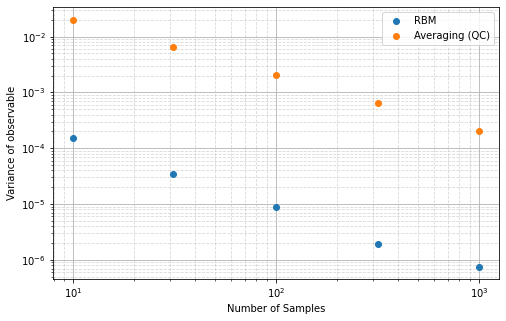

In [ ]:
rbms = np.load('lih2-result.npy')
n_samples = np.logspace(1, 3, num=5).astype(np.int)

plt.figure(figsize=(8,5))
y = np.var(np.real(rbms), axis=1)
plt.loglog(n_samples,y, 'o', label='RBM')
plt.loglog(n_samples,vars/n_samples, 'o', label='Averaging (QC)')
# plt.loglog(n_samples, np.real(np.mean((data - np.linalg.eigh(operator)[0].min())**2, axis=1)))
plt.xlabel("Number of Samples")
plt.ylabel("Variance of observable")
plt.legend()
plt.grid()
plt.grid(which='minor', ls='--', alpha=0.5)
plt.savefig("var-results.png")

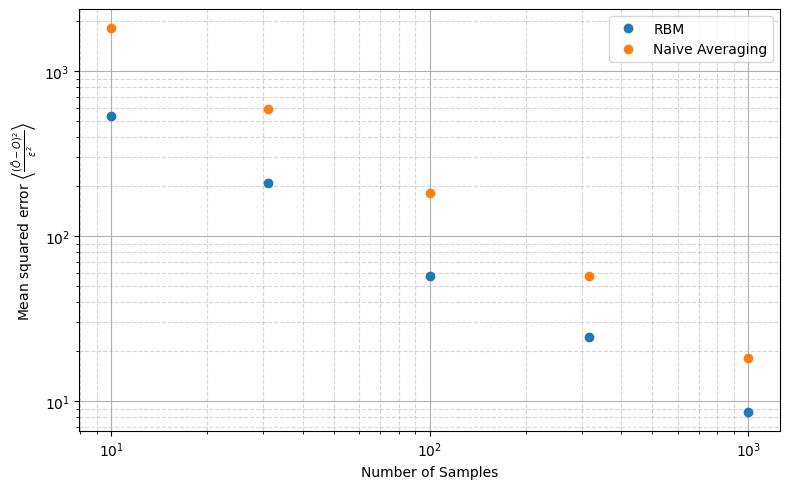

In [ ]:
plt.figure(figsize=(8,5), dpi=100)
y1 = np.mean((np.real(rbms) - np.linalg.eigvalsh(operator)[0])**2, axis=1)
# y2 = np.mean((np.real(bayesians) - np.linalg.eigvalsh(operator)[0])**2, axis=1)
eps = 0.0016
plt.loglog(n_samples,y1/eps**2, 'o', label='RBM')
# plt.loglog(n_samples,y2, 'o', label='Bayesian')
plt.loglog(n_samples,(vars/n_samples)/eps**2, 'o', label='Naive Averaging')
plt.xlabel("Number of Samples")
plt.ylabel(r"Mean squared error $\left\langle \frac{(\tilde{O} - O)^2}{\epsilon^2} \right\rangle$")
plt.legend()
plt.grid()
plt.grid(which='minor', ls='--', alpha=0.5)
plt.tight_layout()
plt.savefig("mse-results.png")

# Full Bayesian

In [ ]:
from scipy.optimize import *

N = 4
operator = get_qubit_op(1.5)[0]
def param_2_psi(param):
    ampl = param[:len(param)//2+1]
    phase = np.insert(param[len(param)//2+1:], 0, 0)
    return ampl * np.exp(1j* phase)
def nll(param, measurements):
    psi = param_2_psi(param)[:,np.newaxis]
    probs = np.abs(np.conjugate(measurements) @ psi)**2
    return -np.mean(np.log(probs))

In [ ]:
constr = NonlinearConstraint(lambda param: np.linalg.norm(param[:len(param)//2+1]), 1, 1, jac='cs')
measurements = np.concatenate([measure(psi, 250, label) for label in paulis], axis=0)
x0 = np.random.normal(size=2**N*2-1)
x0[:len(x0)//2+1] = x0[:len(x0)//2+1]/np.linalg.norm(x0[:len(x0)//2+1])
ret = minimize(nll, x0=x0, args=(measurements,), constraints=(constr,))

In [ ]:
print(Statevector(param_2_psi(ret['x'])).expectation_value(operator.to_matrix()))
start = ret['x']

(-1.0890731173357489+5.551115123125783e-17j)


In [ ]:
from tqdm.notebook import trange
bayesians = []
n_samples = np.logspace(1, 3, num=5).astype(np.int)
# x0 = np.random.normal(size=2**N*2-1)
# x0[:len(x0)//2+1] = x0[:len(x0)//2+1]/np.linalg.norm(x0[:len(x0)//2+1])
for n_sample in n_samples:
    bayesians.append([])
    for i in trange(100):
        x0 = start + np.random.normal(scale=1e-3, size=len(start))
        measurements = np.concatenate([measure(psi, n_sample, label) for label in paulis], axis=0)
        ret = minimize(nll, x0=x0, args=(measurements,), constraints=(constr,),)
        energy = np.real(Statevector(param_2_psi(ret['x'])).expectation_value(operator.to_matrix()))
        bayesians[-1].append(energy)
        print(energy.round(3), ret['nfev'])

-1.094 568
-1.072 1924
-1.077 863
-1.092 599
-1.059 1390
-1.096 497
-1.098 203
-1.09 963
-1.097 236
-1.082 829
-1.095 500
-1.096 1194
-1.097 268
-1.096 632
-1.09 1524
-1.083 664
-1.096 796
-1.089 962
-1.097 500
-1.093 634
-1.097 269
-1.097 268
-1.084 862
-1.084 1555
-1.094 236
-1.097 598
-1.093 1522
-1.097 597
-1.092 931
-1.097 269
-1.097 203
-1.063 1196
-1.085 932
-1.092 961
-1.096 335
-1.098 234
-1.063 1228
-1.072 1257
-1.051 929
-1.095 568
-1.098 203
-1.098 367
-1.095 565
-1.095 466
-1.097 269
-1.097 236
-1.096 565
-1.096 270
-1.097 236

-1.096 366
-1.091 597
-1.094 1329
-1.097 302
-1.096 203
-1.074 898
-1.089 730
-1.097 236
-1.093 996
-1.096 268
-1.085 599
-1.095 235
-1.097 234
-1.095 500
-1.089 1129
-1.095 664
-1.072 2287
-1.074 865
-1.098 235
-1.093 1228
-1.068 1686
-1.092 666
-1.097 565
-1.083 1293
-1.097 332
-1.09 895
-1.071 1425
-1.097 235
-1.095 533
-1.095 828
-1.098 366
-1.094 632
-1.095 830
-1.098 236
-1.087 928
-1.095 301
-1.097 266
-1.067 1325
-1.094 897
-1.097 302
-1.093

-1.098 598
-1.098 399
-1.096 501
-1.098 237
-1.098 236
-1.098 268
-1.097 269
-1.098 233
-1.099 236
-1.098 270
-1.098 302
-1.097 535
-1.098 268
-1.098 234
-1.098 236
-1.098 202
-1.098 235
-1.098 300
-1.098 202
-1.098 269
-1.098 203
-1.098 202
-1.098 365
-1.097 765
-1.098 202
-1.098 268
-1.097 601
-1.098 203
-1.098 202
-1.098 235
-1.098 302
-1.098 366
-1.098 235
-1.098 301
-1.098 235
-1.096 602
-1.099 202
-1.098 202
-1.098 333
-1.097 400
-1.098 202
-1.098 269
-1.097 695
-1.098 268
-1.098 236
-1.098 236
-1.098 271
-1.098 303
-1.098 236
-1.089 701
-1.098 270
-1.098 302
-1.098 466
-1.098 234
-1.081 1526
-1.098 269
-1.099 236
-1.097 501
-1.098 236
-1.098 236
-1.098 236
-1.098 236
-1.098 268
-1.098 500
-1.096 568
-1.098 367
-1.098 368
-1.09 896
-1.098 301
-1.098 269
-1.098 300
-1.098 365
-1.097 236
-1.099 237
-1.099 267
-1.098 368
-1.098 237
-1.098 237
-1.098 202
-1.098 236
-1.098 300
-1.099 234
-1.098 202
-1.098 236
-1.098 400
-1.098 367
-1.096 569
-1.098 235
-1.098 203
-1.098 169
-1.097 235

-1.099 201
-1.099 236
-1.099 236
-1.099 202
-1.099 202
-1.099 335
-1.099 202
-1.099 669
-1.099 236
-1.099 268
-1.099 299
-1.099 235
-1.099 235
-1.099 236
-1.099 234
-1.099 269
-1.099 234
-1.099 202
-1.099 267
-1.099 236
-1.098 236
-1.097 337
-1.099 270
-1.099 269
-1.099 202
-1.099 236
-1.099 266
-1.099 236
-1.099 236
-1.092 702
-1.099 234
-1.099 236
-1.099 270
-1.099 203
-1.099 236
-1.099 236
-1.099 234
-1.099 570
-1.098 372
-1.098 302
-1.098 303
-1.099 236
-1.099 234
-1.099 236
-1.099 269
-1.099 302
-1.099 236
-1.099 269
-1.099 236
-1.099 202
-1.099 204
-1.099 301
-1.099 203
-1.098 366
-1.099 267
-1.099 202
-1.099 234
-1.099 301
-1.099 302
-1.099 236
-1.099 301
-1.099 202
-1.099 235
-1.098 202
-1.099 202
-1.099 367
-1.099 236
-1.099 202
-1.099 236
-1.098 269
-1.099 202
-1.099 300
-1.099 202
-1.099 270
-1.098 335
-1.098 236
-1.099 402
-1.099 268
-1.099 268
-1.099 201
-1.099 233
-1.098 303
-1.099 269
-1.099 268
-1.099 236
-1.099 302
-1.099 203
-1.099 301
-1.099 236
-1.099 201
-1.099 236

-1.099 301
-1.099 168
-1.099 235
-1.099 302
-1.099 201
-1.099 300
-1.099 202
-1.099 202
-1.099 202
-1.099 301
-1.099 301
-1.099 201
-1.099 267
-1.099 437
-1.099 268
-1.099 435
-1.099 270
-1.099 202
-1.099 235
-1.099 202
-1.099 337
-1.099 202
-1.099 169
-1.099 234
-1.099 202
-1.099 468
-1.099 201
-1.099 201
-1.099 235
-1.099 268
-1.099 301
-1.099 268
-1.099 201
-1.099 234
-1.099 202
-1.099 202
-1.099 269
-1.099 333
-1.099 202
-1.099 270
-1.099 300
-1.099 236
-1.099 237
-1.099 202
-1.099 201
-1.099 268
-1.099 300
-1.099 270
-1.099 202
-1.099 268
-1.099 202
-1.099 202
-1.099 203
-1.099 201
-1.099 202
-1.099 270
-1.099 234
-1.099 202
-1.098 600
-1.099 202
-1.099 335
-1.099 269
-1.099 233
-1.099 202
-1.099 236
-1.099 202
-1.099 302
-1.099 202
-1.099 169
-1.099 202
-1.099 234
-1.099 201
-1.099 337
-1.099 235
-1.099 235
-1.099 201
-1.099 236
-1.099 233
-1.099 202
-1.099 234
-1.099 235
-1.099 268
-1.099 203
-1.099 268
-1.099 236
-1.099 202
-1.099 201
-1.099 202
-1.099 233
-1.099 202
-1.099 437

-1.099 269
-1.099 235
-1.099 200
-1.099 202
-1.099 202
-1.099 265
-1.099 234
-1.099 201
-1.099 167
-1.099 202
-1.099 268
-1.099 273
-1.099 234
-1.099 236
-1.099 202
-1.099 234
-1.099 200
-1.099 270
-1.099 269
-1.099 202
-1.099 202
-1.099 202
-1.099 234
-1.099 168
-1.099 200
-1.099 336
-1.099 202
-1.099 201
-1.099 234
-1.099 236
-1.099 236
-1.099 234
-1.099 302
-1.099 202
-1.099 202
-1.099 201
-1.099 234
-1.099 268
-1.099 200
-1.099 201
-1.099 302
-1.099 202
-1.099 202
-1.099 268
-1.099 201
-1.099 202
-1.099 202
-1.099 299
-1.099 200
-1.099 234
-1.099 200
-1.099 234
-1.099 237
-1.099 202
-1.099 269
-1.099 202
-1.099 300
-1.099 236
-1.099 270
-1.099 201
-1.099 266
-1.099 202
-1.099 234
-1.099 235
-1.099 202
-1.099 302
-1.099 202
-1.099 334
-1.099 201
-1.099 270
-1.099 169
-1.099 302
-1.099 202
-1.099 201
-1.099 234
-1.099 268
-1.099 201
-1.099 234
-1.099 201
-1.099 302
-1.099 267
-1.099 300
-1.099 268
-1.099 268
-1.099 202
-1.099 234
-1.099 202
-1.099 234
-1.099 235
-1.099 234
-1.099 302

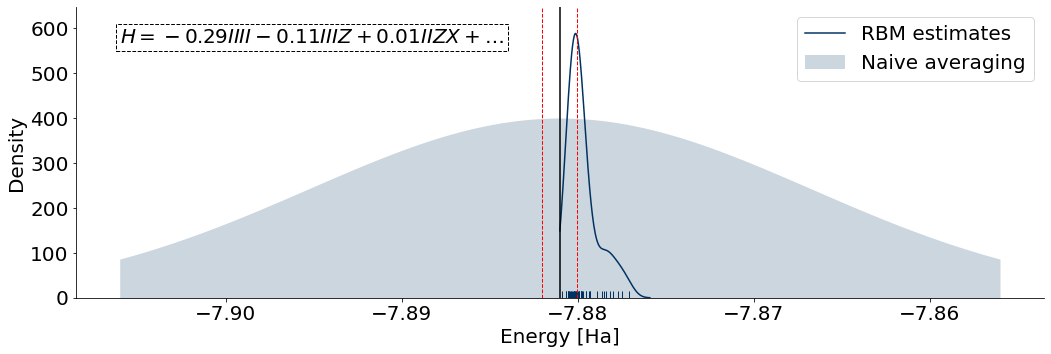

In [ ]:
import seaborn as sns
import matplotlib as mpl
mpl.rc('font', size=20)
operator, shift = get_qubit_op(1.5)
ops = operator
expect = np.real(np.array([sv.expectation_value(op.to_matrix())/op.coeff for op in ops]))
coeffs = np.array([op.coeff for op in ops])
vars = np.sum(coeffs**2 * (1-expect**2))
operator = operator.to_matrix()
rbms = np.load('rbm-result.npy') + shift
true_gnd = np.linalg.eigvalsh(operator).min()+ shift
sns.displot(np.real(rbms)[-1], clip=(true_gnd, np.inf), kind='kde', aspect=3, rug=True, label='RBM estimates', color='#003262')
plt.text(-7.906, 580, s=f'$H = -0.29 IIII -0.11 IIIZ + 0.01 IIZX+\ldots$', ha='left', va='center', bbox={'ec': 'black', 'fc': 'None', 'ls': '--'})
plt.axvline(x=true_gnd, c='black')
plt.axvline(x=true_gnd-eps, ls='--', c='red', lw=1)
plt.axvline(x=true_gnd+eps, ls='--', c='red', lw=1)
tmp = np.linspace(true_gnd-0.025,true_gnd+0.025, num=100)
sigma = np.sqrt(vars/1000)
f = 1/(sigma * np.sqrt(2*np.pi)) * np.exp(-0.5*(tmp-true_gnd)**2/sigma**2)
f = f/f.max() * 400
plt.fill_between(tmp, np.zeros(len(f)), f, color='#003262', alpha=0.2, label='Naive averaging', lw=0)
plt.legend()
plt.tight_layout()
plt.xlabel('Energy [Ha]')
plt.savefig('rbm-result.pdf', bbox_inches='tight')

In [ ]:

len(AbelianGrouper().convert(get_qubit_op(1.5)[0]))

20

In [ ]:
from qiskit.aqua.operators.converters import AbelianGrouper
grouped = AbelianGrouper().convert(op)
len(grouped), len(op)

(24, 105)

In [ ]:
op, _ = get_qubit_op(0.7)

In [ ]:
from tqdm.auto import trange
from qiskit.quantum_info import random_statevector, random_density_matrix

XX = []
ZZ = []
for _ in trange(100000):
    # psi = np.random.uniform(-100,100,size=4) + 1j*np.random.uniform(-100,100,size=4)
    # psi = psi/np.linalg.norm(psi)
    psi = random_statevector(dims=4)
    XX.append(psi.expectation_value(Pauli('XI')))
    ZZ.append(psi.expectation_value(Pauli('IZ')))
XX = np.array(XX)
ZZ = np.array(ZZ)

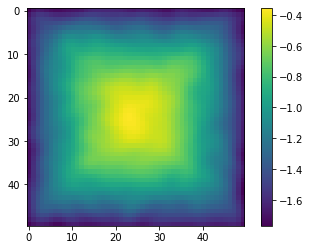

In [ ]:
import seaborn as sns
from sklearn.neighbors import KernelDensity
kd = KernelDensity(bandwidth=5e-2).fit(np.stack([XX,ZZ]).T)
x_grid, y_grid = np.meshgrid(np.linspace(-0.9,0.9,60),np.linspace(-0.9,0.9,60))
samples = kd.score_samples(np.stack((x_grid,y_grid)).reshape((2,-1)).T)

# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# ax.plot_surface(x_grid, y_grid, samples.reshape(x_grid.shape))
plt.imshow(samples.reshape(x_grid.shape)[5:-5,5:-5])
plt.colorbar()

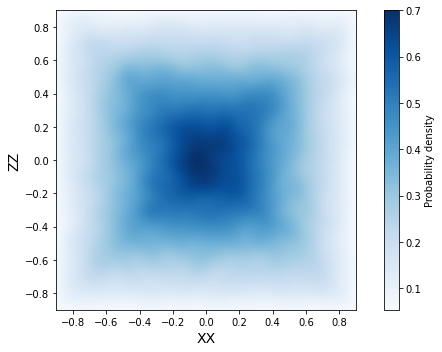

In [ ]:
plt.figure(figsize=(8,5))
plt.imshow(np.exp(samples.reshape(x_grid.shape)), interpolation='bilinear', extent=[-0.9,0.9,-0.9,0.9], cmap='Blues')
plt.xlabel('XX', fontdict={'size': 14})
plt.ylabel('ZZ', fontdict={'size': 14})
plt.colorbar(label='Probability density')
plt.tight_layout()
plt.savefig('cond.png')

[[1.         0.16499103]
 [0.16499103 0.9961237 ]]


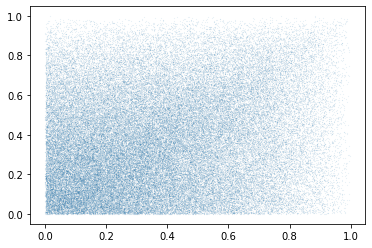

In [ ]:
plt.scatter(np.abs(XX), np.abs(ZZ), s=1e-3)
cov = np.cov(np.stack((np.abs(XX), np.abs(ZZ))))
print(cov/cov[0,0])